In [46]:
# Test installation
import rdkit
from rdkit import Chem
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client

print(" All imports successful")
print(f"RDKit version: {rdkit.__version__}")
print(f"Pandas version: {pd.__version__}")

 All imports successful
RDKit version: 2025.09.2
Pandas version: 2.3.3


In [2]:
# Core libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski
from rdkit.Chem import Draw, PandasTools
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import xgboost as xgb
import lightgbm as lgb
import shap

# Dimensionality reduction
from umap import UMAP

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment configured successfully")

Environment configured successfully


In [3]:
# Initialize ChEMBL client
targets = new_client.target
activities = new_client.activity

# Search for BRAF V600E target
# ChEMBL ID: CHEMBL5145 corresponds to BRAF V600E mutant
target_query = targets.filter(target_chembl_id='CHEMBL5145')
target_data = pd.DataFrame.from_records(target_query)

print(f"Target information retrieved: {target_data.shape[0]} record(s)")
print(f"Target name: {target_data['pref_name'].values[0]}")
print(f"Organism: {target_data['organism'].values[0]}")

Target information retrieved: 2 record(s)
Target name: Serine/threonine-protein kinase B-raf
Organism: Homo sapiens


In [4]:
# Query bioactivity data for BRAF V600E
# Focus on IC50 measurements as primary endpoint
bioactivity_data = activities.filter(
    target_chembl_id='CHEMBL5145',
    type='IC50',
    relation='=',
    assay_type='B'  # Binding assay
)

# Convert to DataFrame
df_bioactivity = pd.DataFrame.from_records(bioactivity_data)

print(f"Total bioactivity records retrieved: {df_bioactivity.shape[0]}")
print(f"Columns available: {df_bioactivity.shape[1]}")

Total bioactivity records retrieved: 8947
Columns available: 46


In [5]:
# Display key columns for quality assessment
relevant_cols = [
    'molecule_chembl_id',
    'canonical_smiles', 
    'standard_value',
    'standard_units',
    'standard_type',
    'pchembl_value'
]

# Filter to existing columns only
available_cols = [col for col in relevant_cols if col in df_bioactivity.columns]
df_subset = df_bioactivity[available_cols].copy()

print("Sample of retrieved data:")
print(df_subset.head(10))
print(f"\nMissing values per column:")
print(df_subset.isnull().sum())

Sample of retrieved data:
  molecule_chembl_id                                   canonical_smiles  \
0       CHEMBL371694        CC(C)(C)c1nc(-c2ccc(F)cc2)c(-c2ccncc2)[nH]1   
1       CHEMBL371694        CC(C)(C)c1nc(-c2ccc(F)cc2)c(-c2ccncc2)[nH]1   
2       CHEMBL200259        OCc1cccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)c1   
3        CHEMBL68215         Oc1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1   
4       CHEMBL200863  CC(C)(CNC(=O)Nc1ccc(Cl)cc1)c1nc(-c2ccc(Cl)c(O)...   
5       CHEMBL381447  CC(C)(CNS(C)(=O)=O)c1nc(-c2ccc(Cl)c(O)c2)c(-c2...   
6       CHEMBL426476  CN(C)CCCNC(=O)c1nc(-c2ccc(Cl)c(O)c2)c(-c2ccncc...   
7       CHEMBL200889   CC(C)(CN)c1nc(-c2ccc(Cl)c(O)c2)c(-c2ccncc2)[nH]1   
8       CHEMBL200320  NCc1ccc(-c2nc(-c3ccc(Cl)c(O)c3)c(-c3ccncc3)[nH...   
9       CHEMBL200118                  Oc1cc(-c2[nH]cnc2-c2ccncc2)ccc1Cl   

  standard_value standard_units standard_type pchembl_value  
0          900.0             nM          IC50          6.05  
1          900.0        

In [7]:
import os

# Create directory structure if it does not exist
os.makedirs('data/raw', exist_ok=True)

# Persist raw data for reproducibility
output_path = 'data/raw/braf_v600e_bioactivity_raw.csv'
df_bioactivity.to_csv(output_path, index=False)

print(f"Raw data saved to: {output_path}")
print(f"Total compounds: {df_bioactivity['molecule_chembl_id'].nunique()}")

Raw data saved to: data/raw/braf_v600e_bioactivity_raw.csv
Total compounds: 5382


### Data cleaning and preprocessing

In [8]:
# Reload data for processing pipeline
df = pd.read_csv('data/raw/braf_v600e_bioactivity_raw.csv')

# Filter records with valid SMILES and standard values
df_clean = df[df['canonical_smiles'].notna()].copy()
df_clean = df_clean[df_clean['standard_value'].notna()].copy()

# Convert standard_value to numeric, handling any non-numeric entries
df_clean['standard_value'] = pd.to_numeric(df_clean['standard_value'], errors='coerce')
df_clean = df_clean[df_clean['standard_value'].notna()].copy()

# Remove duplicates based on SMILES
df_clean = df_clean.drop_duplicates(subset=['canonical_smiles'], keep='first')

print(f"Records after cleaning: {len(df_clean)}")
print(f"Unique compounds: {df_clean['molecule_chembl_id'].nunique()}")
print(f"\nStandard value statistics (nM):")
print(df_clean['standard_value'].describe())

Records after cleaning: 5381
Unique compounds: 5381

Standard value statistics (nM):
count    5.381000e+03
mean     1.262356e+04
std      4.842529e+05
min      2.000000e-02
25%      3.640000e+00
50%      2.100000e+01
75%      3.000000e+02
max      2.500034e+07
Name: standard_value, dtype: float64


In [9]:
# Convert IC50 values from nM to pIC50 for modeling
# pIC50 = -log10(IC50 in M) = -log10(IC50_nM * 10^-9)
# This transformation normalizes the activity scale

df_clean['pIC50'] = -np.log10(df_clean['standard_value'] * 1e-9)

# Remove any infinite or invalid pIC50 values
df_clean = df_clean[np.isfinite(df_clean['pIC50'])].copy()

print(f"pIC50 range: {df_clean['pIC50'].min():.2f} to {df_clean['pIC50'].max():.2f}")
print(f"Mean pIC50: {df_clean['pIC50'].mean():.2f}")
print(f"Median pIC50: {df_clean['pIC50'].median():.2f}")

pIC50 range: 1.60 to 10.70
Mean pIC50: 7.43
Median pIC50: 7.68


In [10]:
# Define activity threshold for binary classification
# pIC50 > 6.0 corresponds to IC50 < 1 uM (commonly used cutoff)
activity_threshold = 6.0

df_clean['activity_class'] = df_clean['pIC50'].apply(
    lambda x: 'active' if x >= activity_threshold else 'inactive'
)

# Display class distribution
class_counts = df_clean['activity_class'].value_counts()
print("Activity distribution:")
print(class_counts)
print(f"\nActive ratio: {class_counts['active'] / len(df_clean):.2%}")

Activity distribution:
activity_class
active      4574
inactive     807
Name: count, dtype: int64

Active ratio: 85.00%


In [11]:
# Parse SMILES and validate molecular structures
# Invalid SMILES will be removed from dataset
valid_mols = []
valid_indices = []

for idx, smiles in enumerate(df_clean['canonical_smiles']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_mols.append(mol)
        valid_indices.append(idx)

# Filter dataframe to valid molecules only
df_clean = df_clean.iloc[valid_indices].reset_index(drop=True)
df_clean['mol'] = valid_mols

print(f"Valid molecular structures: {len(df_clean)}")
print(f"Invalid SMILES removed: {len(df) - len(df_clean)}")

Valid molecular structures: 5381
Invalid SMILES removed: 3566


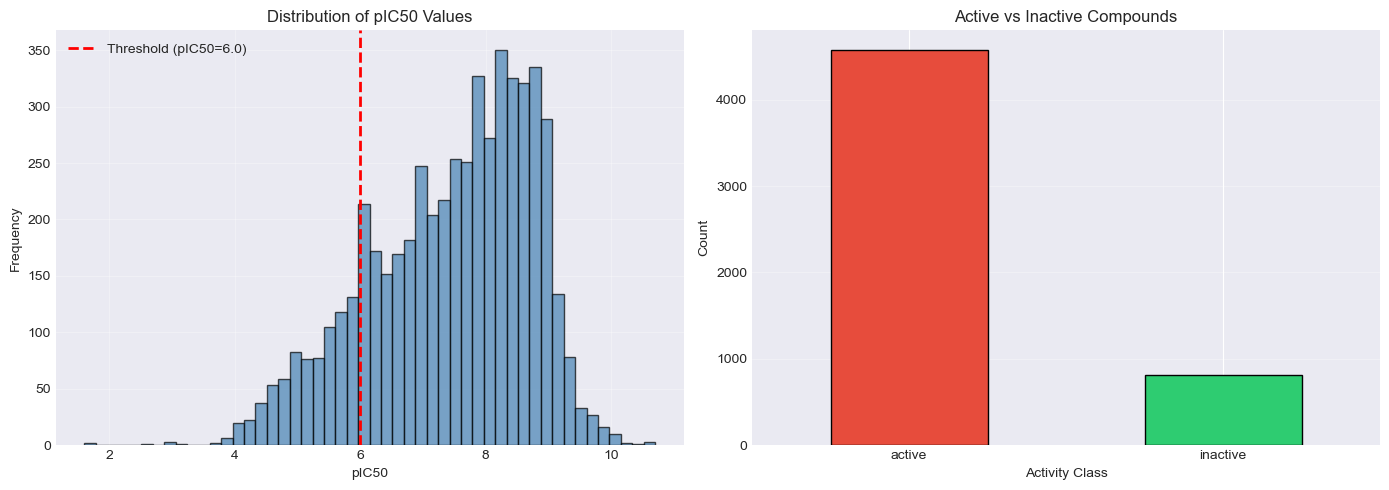

Figure saved to results/figures/activity_distribution.png


In [13]:
# Create results directory if needed
os.makedirs('results/figures', exist_ok=True)

# Plot pIC50 distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of pIC50 values
axes[0].hist(df_clean['pIC50'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(activity_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (pIC50={activity_threshold})')
axes[0].set_xlabel('pIC50')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of pIC50 Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar plot of activity classes
class_counts.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].set_xlabel('Activity Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Active vs Inactive Compounds')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to results/figures/activity_distribution.png")

In [15]:
# Create processed data directory if needed
os.makedirs('data/processed', exist_ok=True)

# Save cleaned dataset for featurization step
output_path = 'data/processed/braf_v600e_cleaned.csv'
df_clean[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'pIC50', 'activity_class']].to_csv(
    output_path, index=False
)

print(f"Processed data saved to: {output_path}")
print(f"Final dataset size: {len(df_clean)} compounds")

Processed data saved to: data/processed/braf_v600e_cleaned.csv
Final dataset size: 5381 compounds


### Featurization

In [16]:
# Load preprocessed dataset
df = pd.read_csv('data/processed/braf_v600e_cleaned.csv')

# Regenerate RDKit molecule objects from SMILES
# Required for descriptor calculation and fingerprint generation
df['mol'] = df['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# Remove any molecules that failed to parse (safety check)
df = df[df['mol'].notna()].reset_index(drop=True)

print(f"Dataset loaded: {len(df)} compounds")
print(f"pIC50 range: {df['pIC50'].min():.2f} - {df['pIC50'].max():.2f}")

Dataset loaded: 5381 compounds
pIC50 range: 1.60 - 10.70


In [17]:
# Generate Morgan (circular) fingerprints for molecular representation
#Radius=2 is equivalent to ECFP4 (Extended Connectivity Fingerprints)
# nBits=2048 provides good balance between information and dimensionality

def generate_morgan_fingerprint(mol, radius=2, nBits=2048):
    """
    Convert molecule to Morgan fingerprint bit vector.
    Returns numpy array of binary features.
    """
    if mol is None:
        return np.zeros(nBits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return np.array(fp)

# Apply fingerprint generation to all molecules
morgan_fps = np.array([generate_morgan_fingerprint(mol) for mol in df['mol']])

print(f"Morgan fingerprints generated: {morgan_fps.shape}")
print(f"Feature dimensions: {morgan_fps.shape[1]} bits")
print(f"Sparsity: {(morgan_fps == 0).sum() / morgan_fps.size:.2%}")

[18:20:22] DEPRECATION WARNING: please use MorganGenerator
[18:20:22] DEPRECATION WARNING: please use MorganGenerator
[18:20:22] DEPRECATION WARNING: please use MorganGenerator
[18:20:22] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerator
[18:20:23] DEPRECATION WARNING: please use MorganGenerat

Morgan fingerprints generated: (5381, 2048)
Feature dimensions: 2048 bits
Sparsity: 96.92%


In [18]:
# Calculate physicochemical descriptors using RDKit
# These complement fingerprints with interpretable chemical properties

def calculate_descriptors(mol):
    """
    Compute standard molecular descriptors for QSAR modeling.
    Returns dictionary of descriptor values.
    """
    if mol is None:
        return {}
    
    return {
        'MolWt': Descriptors.MolWt(mol),                    # Molecular weight
        'LogP': Descriptors.MolLogP(mol),                   # Lipophilicity
        'NumHDonors': Descriptors.NumHDonors(mol),          # Hydrogen bond donors
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),    # Hydrogen bond acceptors
        'TPSA': Descriptors.TPSA(mol),                      # Topological polar surface area
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
        'FractionCSP3': Descriptors.FractionCSP3(mol),      # Fraction of sp3 carbons
        'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
        'MolMR': Descriptors.MolMR(mol)                     # Molar refractivity
    }

# Calculate descriptors for all molecules
descriptors_list = [calculate_descriptors(mol) for mol in df['mol']]
df_descriptors = pd.DataFrame(descriptors_list)

print("Molecular descriptors calculated:")
print(df_descriptors.describe())

Molecular descriptors calculated:
             MolWt         LogP   NumHDonors  NumHAcceptors         TPSA  \
count  5381.000000  5381.000000  5381.000000    5381.000000  5381.000000   
mean    489.033528     4.503144     2.200892       6.807842   103.513269   
std      79.518842     1.142541     0.947491       1.820847    23.056457   
min     247.279000    -0.553500     0.000000       2.000000    29.850000   
25%     442.569000     3.778020     1.000000       5.000000    89.030000   
50%     487.491000     4.500600     2.000000       7.000000   102.410000   
75%     531.614000     5.220820     3.000000       8.000000   117.360000   
max    1412.367000    11.605560    11.000000      19.000000   295.450000   

       NumRotatableBonds  NumAromaticRings  NumAliphaticRings  \
count        5381.000000       5381.000000        5381.000000   
mean            5.950753          3.679242           0.902249   
std             2.086242          0.784417           0.889069   
min             0.000

In [19]:
# Concatenate fingerprints and descriptors into single feature matrix
# Fingerprints capture structural patterns, descriptors add chemical properties

X_fingerprints = morgan_fps
X_descriptors = df_descriptors.values

# Normalize descriptors to similar scale as fingerprints (0-1 range)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_descriptors_scaled = scaler.fit_transform(X_descriptors)

# Combined feature matrix
X_combined = np.hstack([X_fingerprints, X_descriptors_scaled])

print(f"Combined feature matrix shape: {X_combined.shape}")
print(f"Total features: {X_combined.shape[1]} ({X_fingerprints.shape[1]} fingerprint bits + {X_descriptors_scaled.shape[1]} descriptors)")

# Check descriptor correlations to identify potential multicollinearity
correlation_matrix = df_descriptors.corr()
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                   for x, y in zip(*high_corr) if x != y and x < y]

if high_corr_pairs:
    print(f"\nHighly correlated descriptor pairs (|r| > 0.8):")
    for desc1, desc2, corr in high_corr_pairs:
        print(f"  {desc1} <-> {desc2}: {corr:.3f}")

Combined feature matrix shape: (5381, 2060)
Total features: 2060 (2048 fingerprint bits + 12 descriptors)

Highly correlated descriptor pairs (|r| > 0.8):
  MolWt <-> MolMR: 0.917


In [20]:
# Split data maintaining distribution of activity levels
# Stratification ensures similar pIC50 distribution in train and test sets

y = df['pIC50'].values

# Create activity bins for stratification (ensures balanced split across activity ranges)
y_bins = pd.cut(y, bins=5, labels=False)

# 80/20 train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y_bins
)

print(f"Training set: {X_train.shape[0]} compounds")
print(f"Test set: {X_test.shape[0]} compounds")
print(f"\nTraining pIC50 - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test pIC50 - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Save feature matrices and splits for model training
os.makedirs('data/processed', exist_ok=True)
np.save('data/processed/X_train.npy', X_train)
np.save('data/processed/X_test.npy', X_test)
np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_test.npy', y_test)

print("\nFeature matrices saved to data/processed/")

Training set: 4304 compounds
Test set: 1077 compounds

Training pIC50 - Mean: 7.42, Std: 1.29
Test pIC50 - Mean: 7.45, Std: 1.26

Feature matrices saved to data/processed/


## QSAR Model Training

In [21]:
# Train Random Forest regressor as baseline model
# Random forests are robust to overfitting and provide feature importance

rf_model = RandomForestRegressor(
    n_estimators=100,          # Number of trees in the forest
    max_depth=20,              # Maximum tree depth to prevent overfitting
    min_samples_split=5,       # Minimum samples required to split internal node
    min_samples_leaf=2,        # Minimum samples required at leaf node
    random_state=42,
    n_jobs=-1                  # Use all available cores
)

# Fit model on training data
rf_model.fit(X_train, y_train)

# Generate predictions on both sets
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate performance metrics
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print("Random Forest Performance:")
print(f"  Train R²: {train_r2_rf:.3f} | Test R²: {test_r2_rf:.3f}")
print(f"  Train RMSE: {train_rmse_rf:.3f} | Test RMSE: {test_rmse_rf:.3f}")

Random Forest Performance:
  Train R²: 0.925 | Test R²: 0.733
  Train RMSE: 0.354 | Test RMSE: 0.652


In [22]:
# Train XGBoost regressor for comparison
# Gradient boosting often outperforms random forests on structured data

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,             # Fraction of samples used per tree
    colsample_bytree=0.8,      # Fraction of features used per tree
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

print("XGBoost Performance:")
print(f"  Train R²: {train_r2_xgb:.3f} | Test R²: {test_r2_xgb:.3f}")
print(f"  Train RMSE: {train_rmse_xgb:.3f} | Test RMSE: {test_rmse_xgb:.3f}")

XGBoost Performance:
  Train R²: 0.868 | Test R²: 0.708
  Train RMSE: 0.468 | Test RMSE: 0.682


In [23]:
# Train LightGBM regressor as third comparison
# LightGBM is faster than XGBoost and often achieves comparable performance

lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

y_train_pred_lgb = lgb_model.predict(X_train)
y_test_pred_lgb = lgb_model.predict(X_test)

train_r2_lgb = r2_score(y_train, y_train_pred_lgb)
test_r2_lgb = r2_score(y_test, y_test_pred_lgb)
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
test_rmse_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))

print("LightGBM Performance:")
print(f"  Train R²: {train_r2_lgb:.3f} | Test R²: {test_r2_lgb:.3f}")
print(f"  Train RMSE: {train_rmse_lgb:.3f} | Test RMSE: {test_rmse_lgb:.3f}")

LightGBM Performance:
  Train R²: 0.812 | Test R²: 0.682
  Train RMSE: 0.559 | Test RMSE: 0.711


In [24]:
# Aggregate results for comparison across models
results_summary = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Train R²': [train_r2_rf, train_r2_xgb, train_r2_lgb],
    'Test R²': [test_r2_rf, test_r2_xgb, test_r2_lgb],
    'Train RMSE': [train_rmse_rf, train_rmse_xgb, train_rmse_lgb],
    'Test RMSE': [test_rmse_rf, test_rmse_xgb, test_rmse_lgb],
    'Overfitting Gap': [
        train_r2_rf - test_r2_rf,
        train_r2_xgb - test_r2_xgb,
        train_r2_lgb - test_r2_lgb
    ]
})

print("\nModel Performance Summary:")
print(results_summary.to_string(index=False))

# Identify best model based on test R²
best_model_idx = results_summary['Test R²'].idxmax()
best_model_name = results_summary.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")


Model Performance Summary:
        Model  Train R²  Test R²  Train RMSE  Test RMSE  Overfitting Gap
Random Forest  0.924788 0.732709    0.353652   0.652112         0.192079
      XGBoost  0.868013 0.707699    0.468487   0.681939         0.160314
     LightGBM  0.812314 0.682098    0.558660   0.711176         0.130217

Best performing model: Random Forest


### Model visualization

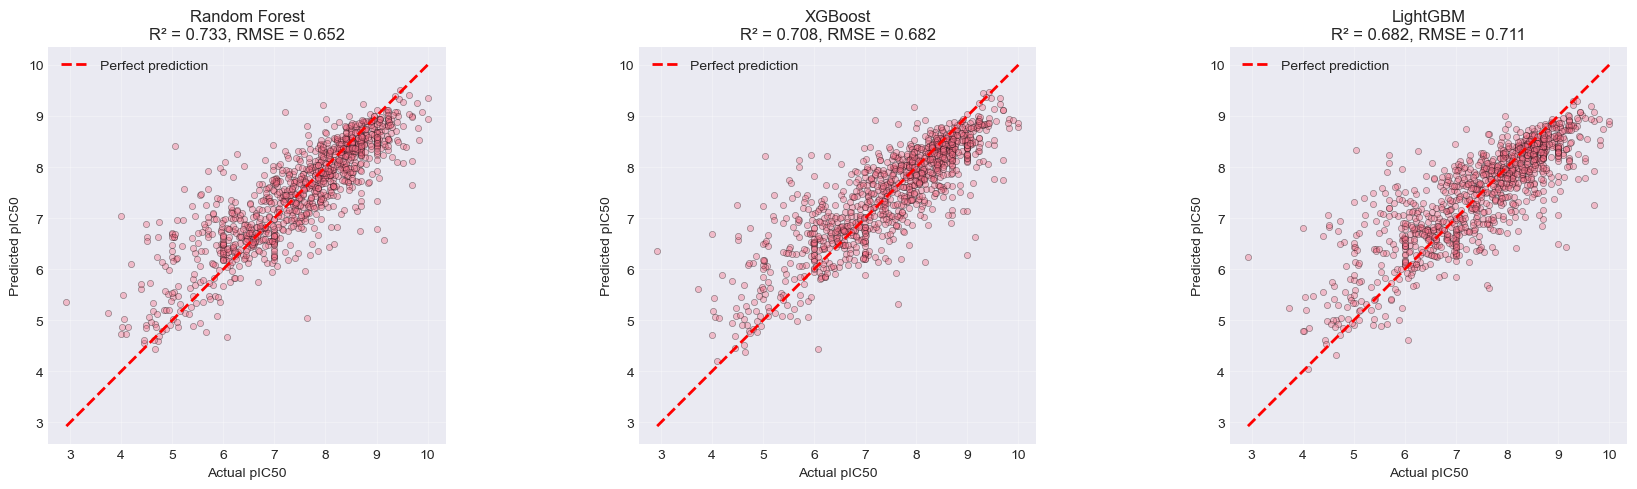

Prediction plots saved


In [25]:
# Visualize model predictions against true values
# Diagonal line represents perfect predictions

os.makedirs('results/figures', exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Random Forest', y_test_pred_rf, test_r2_rf, test_rmse_rf),
    ('XGBoost', y_test_pred_xgb, test_r2_xgb, test_rmse_xgb),
    ('LightGBM', y_test_pred_lgb, test_r2_lgb, test_rmse_lgb)
]

for idx, (name, y_pred, r2, rmse) in enumerate(models_data):
    axes[idx].scatter(y_test, y_pred, alpha=0.4, s=20, edgecolors='k', linewidth=0.5)
    
    # Add perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    axes[idx].set_xlabel('Actual pIC50')
    axes[idx].set_ylabel('Predicted pIC50')
    axes[idx].set_title(f'{name}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('results/figures/model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Prediction plots saved")

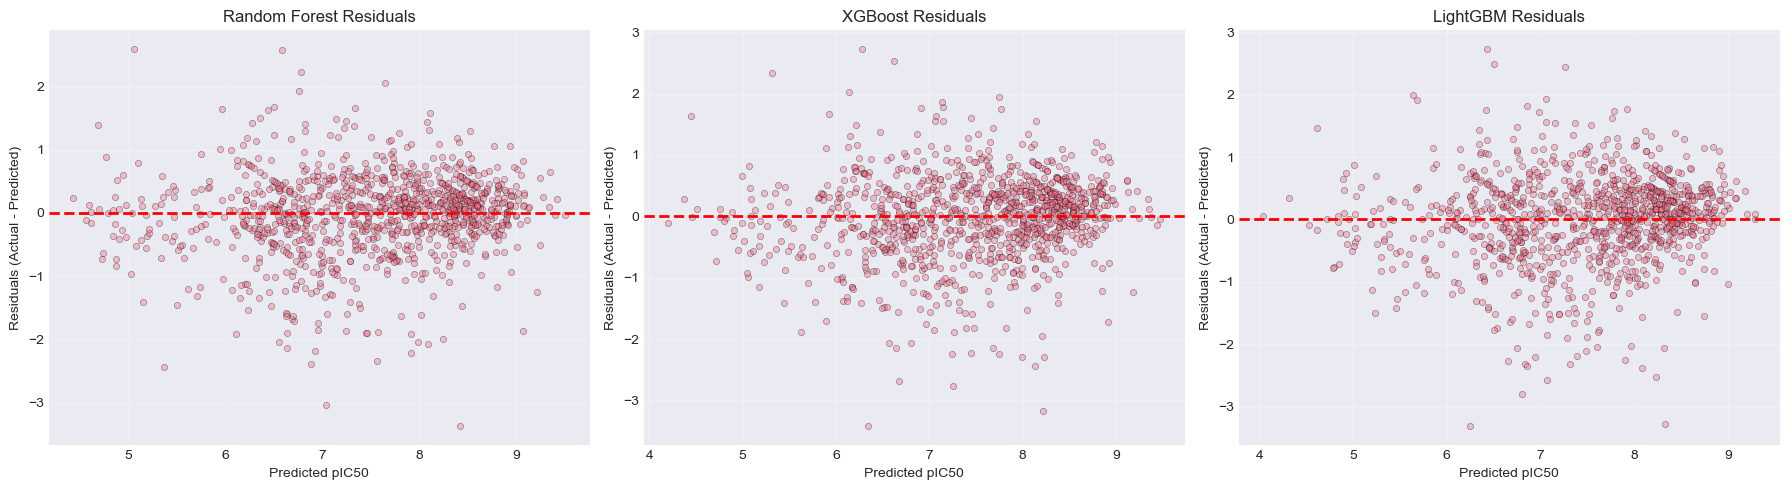

Residual plots saved


In [26]:
# Analyze prediction residuals to identify systematic errors
# Residuals should be randomly distributed around zero

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, y_pred, r2, rmse) in enumerate(models_data):
    residuals = y_test - y_pred
    
    axes[idx].scatter(y_pred, residuals, alpha=0.4, s=20, edgecolors='k', linewidth=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Predicted pIC50')
    axes[idx].set_ylabel('Residuals (Actual - Predicted)')
    axes[idx].set_title(f'{name} Residuals')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Residual plots saved")

In [27]:
# Persist best performing model for future predictions
import pickle

os.makedirs('models', exist_ok=True)

# Save Random Forest model (best performer)
with open('models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save scaler for descriptor normalization
with open('models/descriptor_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature metadata
feature_metadata = {
    'n_fingerprint_bits': 2048,
    'descriptor_names': list(df_descriptors.columns),
    'total_features': X_combined.shape[1]
}

with open('models/feature_metadata.pkl', 'wb') as f:
    pickle.dump(feature_metadata, f)

print("Models and metadata saved to models/")

Models and metadata saved to models/


## Model Interpretation with SHAP

In [28]:
# Initialize SHAP explainer for Random Forest model
# SHAP values quantify each feature's contribution to individual predictions

# Use TreeExplainer for tree-based models (faster than KernelExplainer)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for test set (using subset for computational efficiency)
# Using 500 samples for visualization purposes
n_samples_shap = min(500, len(X_test))
X_test_sample = X_test[:n_samples_shap]
shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP values calculated for {n_samples_shap} test compounds")
print(f"SHAP values shape: {shap_values.shape}")

SHAP values calculated for 500 test compounds
SHAP values shape: (500, 2060)


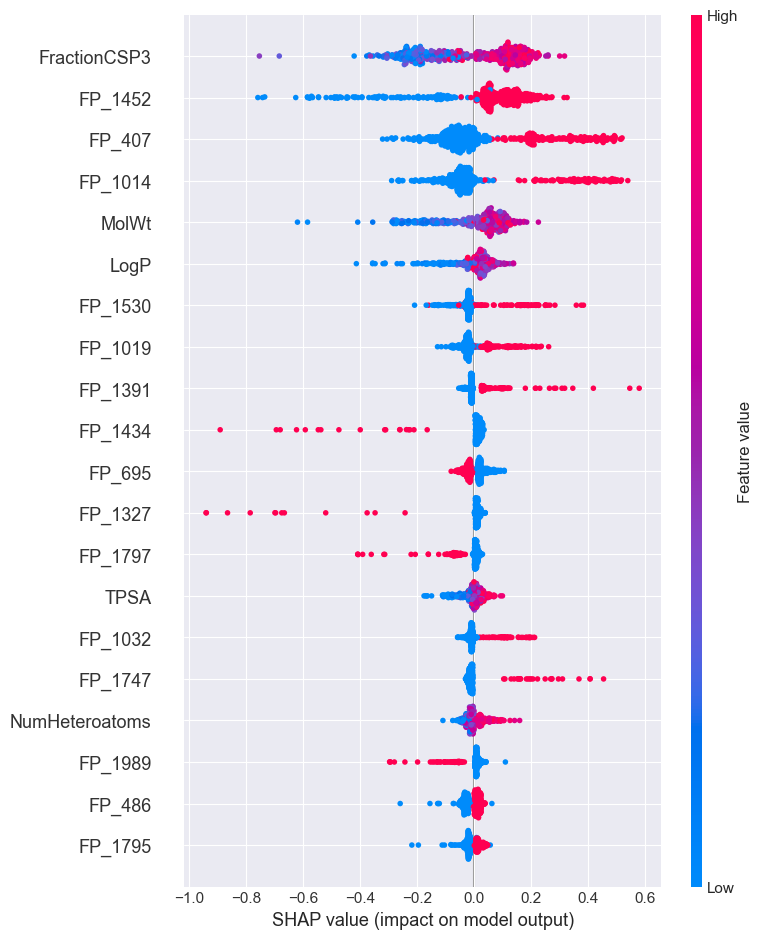

SHAP summary plot saved


In [29]:
# Generate SHAP summary plot showing feature importance
# Each point represents a compound, color indicates feature value (red=high, blue=low)

# Create feature names for interpretability
fingerprint_names = [f'FP_{i}' for i in range(2048)]
descriptor_names = list(df_descriptors.columns)
all_feature_names = fingerprint_names + descriptor_names

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, 
    X_test_sample, 
    feature_names=all_feature_names,
    max_display=20,  # Show top 20 most important features
    show=False
)
plt.tight_layout()
plt.savefig('results/figures/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP summary plot saved")

Descriptor importance ranking:
       Descriptor  Mean |SHAP|
     FractionCSP3     0.150254
            MolWt     0.091405
             LogP     0.047848
             TPSA     0.023950
   NumHeteroatoms     0.022599
            MolMR     0.016444
 NumAromaticRings     0.007481
       NumHDonors     0.005712
    NumHAcceptors     0.004563
NumAliphaticRings     0.004111
NumRotatableBonds     0.003885
NumSaturatedRings     0.001562


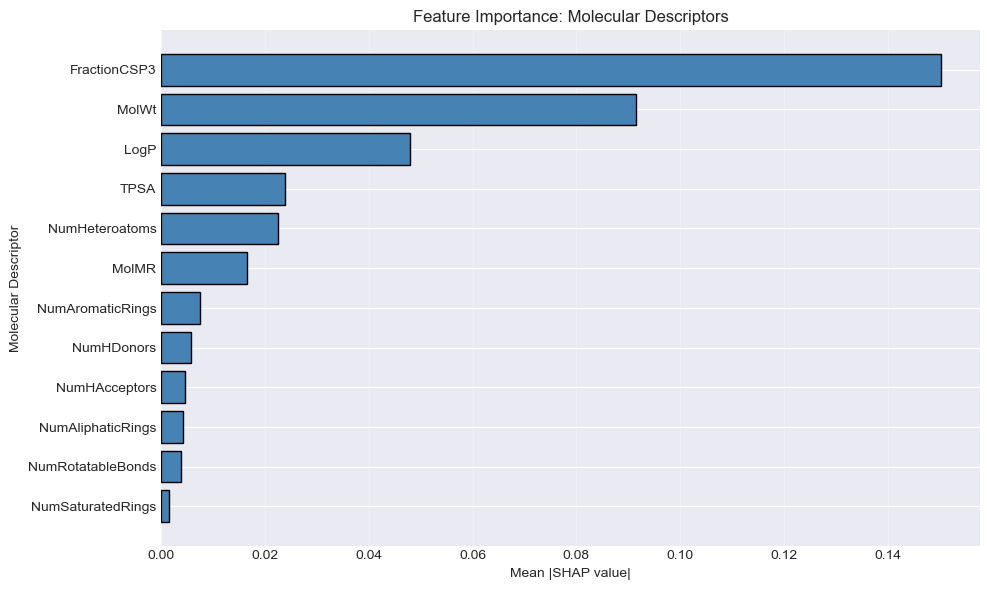

In [30]:
# Focus SHAP analysis on interpretable molecular descriptors
# Extract SHAP values for descriptor features only

descriptor_start_idx = 2048  # Descriptors start after fingerprint bits
shap_descriptors = shap_values[:, descriptor_start_idx:]

# Calculate mean absolute SHAP value per descriptor (global importance)
mean_abs_shap = np.abs(shap_descriptors).mean(axis=0)

# Create importance dataframe
descriptor_importance = pd.DataFrame({
    'Descriptor': descriptor_names,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False)

print("Descriptor importance ranking:")
print(descriptor_importance.to_string(index=False))

# Visualize descriptor importance
plt.figure(figsize=(10, 6))
plt.barh(descriptor_importance['Descriptor'], descriptor_importance['Mean |SHAP|'], color='steelblue', edgecolor='black')
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Molecular Descriptor')
plt.title('Feature Importance: Molecular Descriptors')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/figures/descriptor_importance.png', dpi=300, bbox_inches='tight')
plt.show()

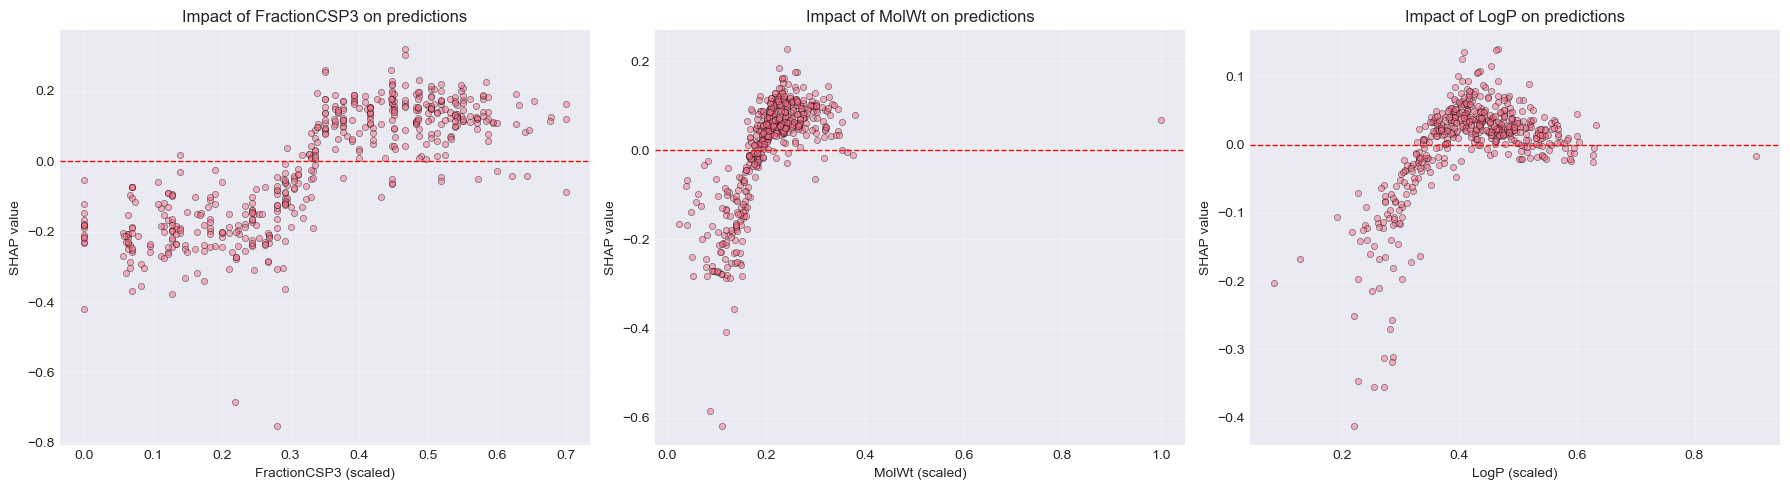

SHAP dependence plots saved


In [31]:
# Plot SHAP dependence for top 3 most important descriptors
# Shows how feature values relate to their impact on predictions

top_descriptors = descriptor_importance.head(3)['Descriptor'].values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, desc_name in enumerate(top_descriptors):
    desc_idx = descriptor_names.index(desc_name)
    feature_idx = descriptor_start_idx + desc_idx
    
    # Extract feature values and SHAP values
    feature_values = X_test_sample[:, feature_idx]
    feature_shap = shap_values[:, feature_idx]
    
    axes[idx].scatter(feature_values, feature_shap, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    axes[idx].set_xlabel(f'{desc_name} (scaled)')
    axes[idx].set_ylabel('SHAP value')
    axes[idx].set_title(f'Impact of {desc_name} on predictions')
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP dependence plots saved")

## ADMET Filtering & Drug-likeness

In [32]:
# Apply Lipinski Rule of Five for oral bioavailability assessment
# Compounds violating >1 rule typically have poor absorption

def lipinski_filter(mol):
    """
    Evaluate Lipinski Rule of Five criteria.
    Returns dict with rule evaluations and violation count.
    """
    if mol is None:
        return None
    
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    
    rules = {
        'MW <= 500': mw <= 500,
        'LogP <= 5': logp <= 5,
        'HBD <= 5': hbd <= 5,
        'HBA <= 10': hba <= 10
    }
    
    violations = sum([not v for v in rules.values()])
    
    return {
        'MW': mw,
        'LogP': logp,
        'HBD': hbd,
        'HBA': hba,
        'Violations': violations,
        'Pass': violations <= 1  # Allow 1 violation per Lipinski
    }

# Apply Lipinski filter to all compounds
df['Lipinski'] = df['mol'].apply(lipinski_filter)
df_lipinski = pd.DataFrame(df['Lipinski'].tolist())
df = pd.concat([df, df_lipinski], axis=1)

print("Lipinski Rule of Five Analysis:")
print(f"Compounds passing (≤1 violation): {df['Pass'].sum()} ({df['Pass'].sum()/len(df)*100:.1f}%)")
print(f"\nViolation distribution:")
print(df['Violations'].value_counts().sort_index())

Lipinski Rule of Five Analysis:
Compounds passing (≤1 violation): 4284 (79.6%)

Violation distribution:
Violations
0    2370
1    1914
2    1074
3      19
4       4
Name: count, dtype: int64


In [33]:
# Apply Veber rules as complementary filter to Lipinski
# Focus on molecular flexibility and polarity

def veber_filter(mol):
    """
    Evaluate Veber criteria for oral bioavailability.
    Complements Lipinski by assessing flexibility and polar surface area.
    """
    if mol is None:
        return None
    
    tpsa = Descriptors.TPSA(mol)
    rotatable = Descriptors.NumRotatableBonds(mol)
    
    pass_veber = (tpsa <= 140) and (rotatable <= 10)
    
    return {
        'TPSA': tpsa,
        'RotBonds': rotatable,
        'Pass_Veber': pass_veber
    }

df['Veber'] = df['mol'].apply(veber_filter)
df_veber = pd.DataFrame(df['Veber'].tolist())
df = pd.concat([df, df_veber], axis=1)

print("Veber Rules Analysis:")
print(f"Compounds passing Veber: {df['Pass_Veber'].sum()} ({df['Pass_Veber'].sum()/len(df)*100:.1f}%)")
print(f"Compounds passing both Lipinski AND Veber: {(df['Pass'] & df['Pass_Veber']).sum()}")

Veber Rules Analysis:
Compounds passing Veber: 5043 (93.7%)
Compounds passing both Lipinski AND Veber: 4072


In [34]:
# Screen for Pan-Assay Interference Compounds (PAINS)
# These substructures cause false positives in biochemical assays

from rdkit.Chem import FilterCatalog

# Load PAINS filter catalog from RDKit
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
pains_catalog = FilterCatalog.FilterCatalog(params)

def check_pains(mol):
    """
    Check if molecule contains PAINS substructures.
    Returns True if compound is clean (no PAINS).
    """
    if mol is None:
        return False
    
    entry = pains_catalog.GetFirstMatch(mol)
    return entry is None  # True if no PAINS found

df['PAINS_clean'] = df['mol'].apply(check_pains)

print("PAINS Filter Analysis:")
print(f"Compounds without PAINS: {df['PAINS_clean'].sum()} ({df['PAINS_clean'].sum()/len(df)*100:.1f}%)")
print(f"Compounds flagged with PAINS: {(~df['PAINS_clean']).sum()}")

PAINS Filter Analysis:
Compounds without PAINS: 5171 (96.1%)
Compounds flagged with PAINS: 210


Combined Drug-likeness Filter:
Total compounds: 5381
Drug-like compounds: 3889 (72.3%)


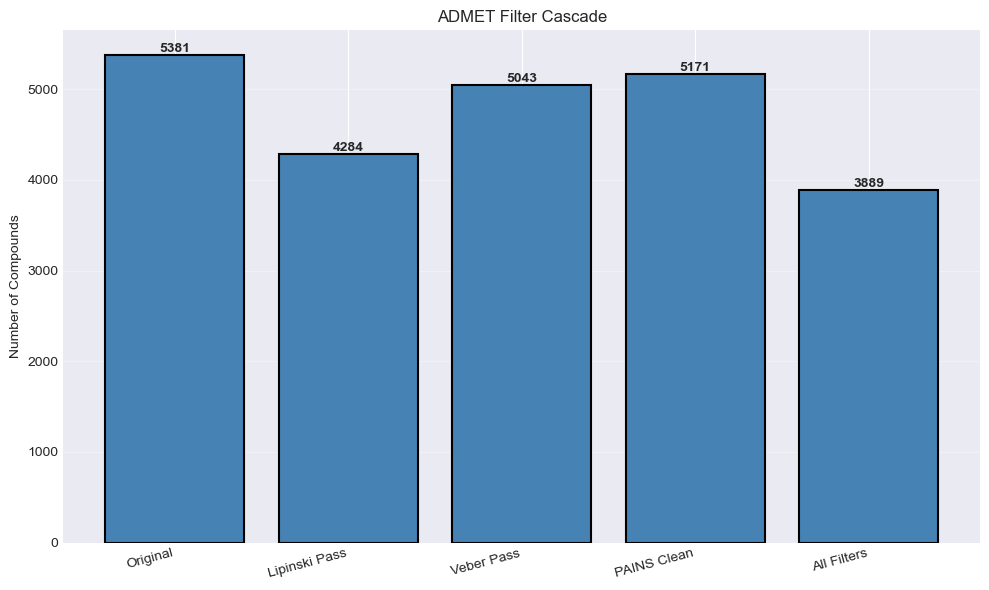

In [35]:
# Combine all filters to define drug-like subset
# Compounds must pass Lipinski, Veber, and PAINS checks

df['DrugLike'] = df['Pass'] & df['Pass_Veber'] & df['PAINS_clean']

print("Combined Drug-likeness Filter:")
print(f"Total compounds: {len(df)}")
print(f"Drug-like compounds: {df['DrugLike'].sum()} ({df['DrugLike'].sum()/len(df)*100:.1f}%)")

# Visualize filter cascade
filter_counts = {
    'Original': len(df),
    'Lipinski Pass': df['Pass'].sum(),
    'Veber Pass': df['Pass_Veber'].sum(),
    'PAINS Clean': df['PAINS_clean'].sum(),
    'All Filters': df['DrugLike'].sum()
}

plt.figure(figsize=(10, 6))
bars = plt.bar(filter_counts.keys(), filter_counts.values(), color='steelblue', edgecolor='black', linewidth=1.5)
plt.ylabel('Number of Compounds')
plt.title('ADMET Filter Cascade')
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/admet_filter_cascade.png', dpi=300, bbox_inches='tight')
plt.show()

##  Chemical Space Analysis with UMAP

In [36]:
# Apply UMAP to visualize chemical space in 2D
# UMAP preserves both local and global structure better than PCA or t-SNE

# Use only fingerprints for chemical similarity (first 2048 features)
X_fingerprints_full = X_combined[:, :2048]

# Initialize UMAP with parameters optimized for molecular data
umap_model = UMAP(
    n_neighbors=15,        # Balance between local and global structure
    min_dist=0.1,          # Minimum distance between points in embedding
    n_components=2,        # 2D projection for visualization
    metric='jaccard',      # Appropriate for binary fingerprints
    random_state=42
)

# Fit and transform fingerprints to 2D space
umap_embedding = umap_model.fit_transform(X_fingerprints_full)

print(f"UMAP embedding computed: {umap_embedding.shape}")
print(f"Embedding range - X: [{umap_embedding[:, 0].min():.2f}, {umap_embedding[:, 0].max():.2f}]")
print(f"Embedding range - Y: [{umap_embedding[:, 1].min():.2f}, {umap_embedding[:, 1].max():.2f}]")

UMAP embedding computed: (5381, 2)
Embedding range - X: [-8.28, 24.45]
Embedding range - Y: [-8.42, 28.90]


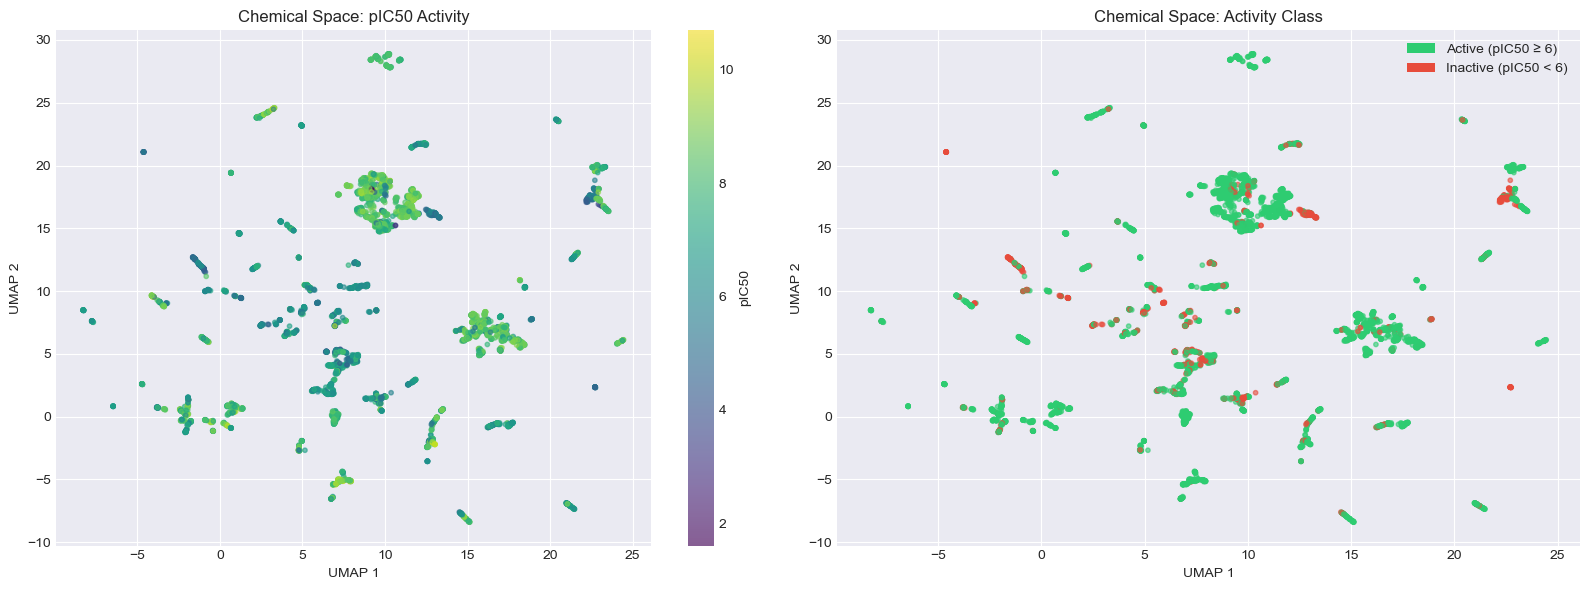

UMAP chemical space visualization saved


In [37]:
# Plot UMAP embedding colored by pIC50 activity
# Reveals if active compounds cluster in chemical space

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by pIC50 (continuous)
scatter1 = axes[0].scatter(
    umap_embedding[:, 0], 
    umap_embedding[:, 1],
    c=df['pIC50'],
    cmap='viridis',
    s=10,
    alpha=0.6
)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('Chemical Space: pIC50 Activity')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('pIC50')

# Plot 2: Colored by activity class (binary)
activity_colors = df['activity_class'].map({'active': '#2ecc71', 'inactive': '#e74c3c'})
axes[1].scatter(
    umap_embedding[:, 0], 
    umap_embedding[:, 1],
    c=activity_colors,
    s=10,
    alpha=0.6
)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('Chemical Space: Activity Class')

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Active (pIC50 ≥ 6)'),
    Patch(facecolor='#e74c3c', label='Inactive (pIC50 < 6)')
]
axes[1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.savefig('results/figures/umap_chemical_space.png', dpi=300, bbox_inches='tight')
plt.show()

print("UMAP chemical space visualization saved")

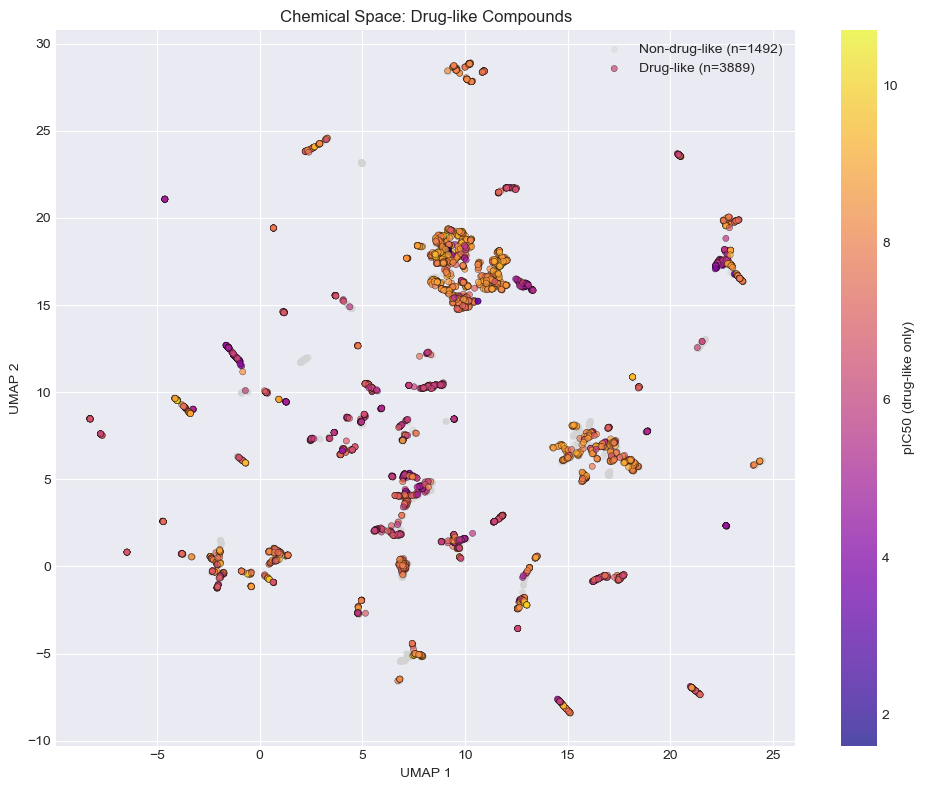

Drug-likeness overlay saved


In [38]:
# Overlay drug-likeness filter on chemical space
# Assess if drug-like compounds occupy specific regions

fig, ax = plt.subplots(figsize=(10, 8))

# Plot drug-like vs non-drug-like compounds
druglike_mask = df['DrugLike'].values
ax.scatter(
    umap_embedding[~druglike_mask, 0],
    umap_embedding[~druglike_mask, 1],
    c='lightgray',
    s=15,
    alpha=0.4,
    label=f'Non-drug-like (n={(~druglike_mask).sum()})'
)
ax.scatter(
    umap_embedding[druglike_mask, 0],
    umap_embedding[druglike_mask, 1],
    c=df.loc[druglike_mask, 'pIC50'],
    cmap='plasma',
    s=20,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.3,
    label=f'Drug-like (n={druglike_mask.sum()})'
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Chemical Space: Drug-like Compounds')
ax.legend()

cbar = plt.colorbar(ax.collections[1], ax=ax)
cbar.set_label('pIC50 (drug-like only)')

plt.tight_layout()
plt.savefig('results/figures/umap_druglike_space.png', dpi=300, bbox_inches='tight')
plt.show()

print("Drug-likeness overlay saved")

In [39]:
# Analyze scaffold diversity using Murcko scaffolds
# Assesses chemical diversity beyond simple clustering

from rdkit.Chem.Scaffolds import MurckoScaffold

def get_murcko_scaffold(mol):
    """
    Extract Murcko scaffold (core structure without side chains).
    Returns SMILES of scaffold or None if extraction fails.
    """
    if mol is None:
        return None
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

df['Scaffold'] = df['mol'].apply(get_murcko_scaffold)

# Count unique scaffolds
unique_scaffolds = df['Scaffold'].nunique()
total_compounds = len(df)
scaffold_ratio = unique_scaffolds / total_compounds

print("Scaffold Diversity Analysis:")
print(f"Total compounds: {total_compounds}")
print(f"Unique Murcko scaffolds: {unique_scaffolds}")
print(f"Scaffold diversity ratio: {scaffold_ratio:.3f}")

# Top 10 most common scaffolds
scaffold_counts = df['Scaffold'].value_counts().head(10)
print(f"\nTop 10 most frequent scaffolds:")
for idx, (scaffold, count) in enumerate(scaffold_counts.items(), 1):
    print(f"  {idx}. {scaffold[:50]}... (n={count})")

Scaffold Diversity Analysis:
Total compounds: 5381
Unique Murcko scaffolds: 1901
Scaffold diversity ratio: 0.353

Top 10 most frequent scaffolds:
  1. O=C(Nc1ccccc1)Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)cc1... (n=59)
  2. c1ccc(Nc2ncnc3ccc(-c4ccccc4)cc23)cc1... (n=58)
  3. O=C(Nc1ccccc1)c1cccc(Nc2ncnc3cnc(N4CCNCC4)nc23)c1... (n=51)
  4. c1ccc(-c2[nH]c(C3CC3)nc2-c2ccncn2)cc1... (n=51)
  5. O=C1CCc2c(Oc3ccc4c(c3)[C@H]3[C@H](NC(=O)Nc5ccccc5)... (n=49)
  6. O=C(Nc1ccccc1)c1cccc(Nc2ncnc3cncnc23)c1... (n=48)
  7. O=c1[nH]cnc2ccc(Nc3ccccc3)cc12... (n=45)
  8. O=C(Nc1cncc(-c2cncc(N3CCOCC3)c2)c1)c1ccncc1... (n=43)
  9. c1ccc(-c2ccc3ncnc(Nc4cccc5[nH]ncc45)c3c2)cc1... (n=41)
  10. O=C(Nc1ccccc1)c1cccc(Nc2ncnc3cnc(N4CCCC4)nc23)c1... (n=39)


## Final Ranking & Candidate Selection

In [40]:
# Reload test set and generate predictions with confidence intervals
# Use best model (Random Forest) for candidate ranking

X_test_loaded = np.load('data/processed/X_test.npy')
y_test_loaded = np.load('data/processed/y_test.npy')

# Generate predictions
y_pred_final = rf_model.predict(X_test_loaded)

# Calculate prediction uncertainty using ensemble variance
# Individual tree predictions provide measure of model confidence
predictions_per_tree = np.array([tree.predict(X_test_loaded) for tree in rf_model.estimators_])
prediction_std = predictions_per_tree.std(axis=0)

print(f"Predictions generated for {len(y_pred_final)} test compounds")
print(f"Mean prediction uncertainty (std): {prediction_std.mean():.3f}")

Predictions generated for 1077 test compounds
Mean prediction uncertainty (std): 0.601


In [41]:
# Create comprehensive ranking table combining predictions and filters
# Prioritize compounds with high predicted activity and good drug-likeness

# Get test set indices (assuming same order as original split)
test_indices = df.index[-len(y_test_loaded):]
df_test = df.loc[test_indices].copy()

# Add predictions and uncertainty
df_test['Predicted_pIC50'] = y_pred_final
df_test['Prediction_Std'] = prediction_std
df_test['Actual_pIC50'] = y_test_loaded

# Calculate prediction error for performance assessment
df_test['Prediction_Error'] = np.abs(df_test['Actual_pIC50'] - df_test['Predicted_pIC50'])

# Composite score: predicted activity minus uncertainty, bonus for drug-likeness
df_test['Composite_Score'] = (
    df_test['Predicted_pIC50'] 
    - 0.5 * df_test['Prediction_Std']  # Penalize uncertain predictions
    + 0.5 * df_test['DrugLike'].astype(int)  # Bonus for drug-likeness
)

# Sort by composite score
df_ranked = df_test.sort_values('Composite_Score', ascending=False).reset_index(drop=True)

print("Top 20 ranked candidates:")
print(df_ranked[['molecule_chembl_id', 'Predicted_pIC50', 'Actual_pIC50', 
                 'Prediction_Std', 'DrugLike', 'Composite_Score']].head(20).to_string(index=True))

Top 20 ranked candidates:
   molecule_chembl_id  Predicted_pIC50  Actual_pIC50  Prediction_Std  DrugLike  Composite_Score
0       CHEMBL5862522         9.394000      9.366532        0.353540      True         9.717230
1       CHEMBL5743167         9.348347     10.000000        0.451757      True         9.622469
2       CHEMBL5935385         9.505891      9.468521        0.797455      True         9.607163
3       CHEMBL6029891         9.243363      8.742321        0.412525      True         9.537100
4       CHEMBL5829669         9.208828      7.958607        0.344923      True         9.536366
5       CHEMBL5790619         9.078230      9.366532        0.194935      True         9.480762
6       CHEMBL6045829         9.125773      9.214670        0.293052      True         9.479247
7       CHEMBL5821326         9.071582      9.187087        0.190048      True         9.476558
8       CHEMBL6057019         9.334858      9.431798        0.728041      True         9.470837
9       CHEMBL

In [42]:
# Focus on top 50 candidates for detailed analysis
top_n = 50
df_top = df_ranked.head(top_n).copy()

print(f"\nTop {top_n} Candidates Analysis:")
print(f"Mean predicted pIC50: {df_top['Predicted_pIC50'].mean():.2f}")
print(f"Mean actual pIC50: {df_top['Actual_pIC50'].mean():.2f}")
print(f"Drug-like ratio: {df_top['DrugLike'].sum()}/{top_n} ({df_top['DrugLike'].sum()/top_n*100:.1f}%)")
print(f"Mean prediction error: {df_top['Prediction_Error'].mean():.3f}")

# Check if model successfully identifies true actives
threshold = 6.0
df_top['True_Active'] = df_top['Actual_pIC50'] >= threshold
df_top['Pred_Active'] = df_top['Predicted_pIC50'] >= threshold

true_positive_rate = (df_top['True_Active'] & df_top['Pred_Active']).sum() / df_top['True_Active'].sum()
print(f"\nTrue positive rate in top {top_n}: {true_positive_rate:.1%}")


Top 50 Candidates Analysis:
Mean predicted pIC50: 9.01
Mean actual pIC50: 9.01
Drug-like ratio: 49/50 (98.0%)
Mean prediction error: 0.287

True positive rate in top 50: 100.0%


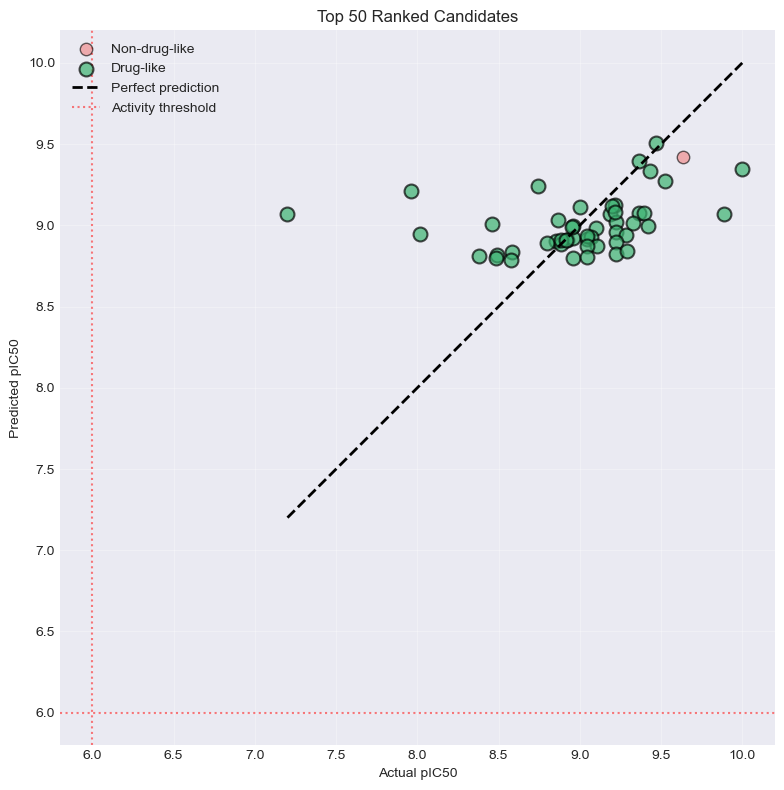

Top candidates visualization saved


In [43]:
# Plot predicted vs actual for top candidates with drug-likeness overlay

fig, ax = plt.subplots(figsize=(10, 8))

# Separate by drug-likeness
drug_like_mask = df_top['DrugLike'].values

ax.scatter(
    df_top.loc[~drug_like_mask, 'Actual_pIC50'],
    df_top.loc[~drug_like_mask, 'Predicted_pIC50'],
    s=80,
    alpha=0.6,
    c='lightcoral',
    edgecolors='black',
    linewidth=1,
    label='Non-drug-like'
)

ax.scatter(
    df_top.loc[drug_like_mask, 'Actual_pIC50'],
    df_top.loc[drug_like_mask, 'Predicted_pIC50'],
    s=100,
    alpha=0.7,
    c='mediumseagreen',
    edgecolors='black',
    linewidth=1.5,
    label='Drug-like'
)

# Perfect prediction line
min_val = min(df_top['Actual_pIC50'].min(), df_top['Predicted_pIC50'].min())
max_val = max(df_top['Actual_pIC50'].max(), df_top['Predicted_pIC50'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect prediction')

# Activity threshold lines
ax.axhline(y=6.0, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label='Activity threshold')
ax.axvline(x=6.0, color='red', linestyle=':', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Actual pIC50')
ax.set_ylabel('Predicted pIC50')
ax.set_title(f'Top {top_n} Ranked Candidates')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('results/figures/top_candidates_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Top candidates visualization saved")

In [44]:
# Export ranked candidates and model performance metrics

os.makedirs('results/metrics', exist_ok=True)

# Save top candidates with full information
df_ranked[['molecule_chembl_id', 'canonical_smiles', 'Predicted_pIC50', 'Actual_pIC50',
           'Prediction_Std', 'DrugLike', 'Pass', 'Pass_Veber', 'PAINS_clean',
           'MW', 'LogP', 'TPSA', 'Composite_Score']].to_csv(
    'results/metrics/ranked_candidates.csv', index=False
)

# Save performance summary
performance_summary = {
    'Model': 'Random Forest',
    'Test_R2': test_r2_rf,
    'Test_RMSE': test_rmse_rf,
    'Train_compounds': len(X_train),
    'Test_compounds': len(X_test),
    'Total_features': X_combined.shape[1],
    'Drug_like_ratio': df['DrugLike'].sum() / len(df),
    'Unique_scaffolds': df['Scaffold'].nunique(),
    'Top_50_true_positive_rate': true_positive_rate
}

performance_df = pd.DataFrame([performance_summary])
performance_df.to_csv('results/metrics/model_performance.csv', index=False)

print("Results saved:")
print("  - results/metrics/ranked_candidates.csv")
print("  - results/metrics/model_performance.csv")
print("\nProject complete.")

Results saved:
  - results/metrics/ranked_candidates.csv
  - results/metrics/model_performance.csv

Project complete.


In [45]:
# Generate comprehensive project summary

print("=" * 80)
print("BRAF V600E QSAR PROJECT - FINAL SUMMARY")
print("=" * 80)

summary_text = f"""
DATA ACQUISITION & PROCESSING
------------------------------
Initial ChEMBL records: 5,382
Final clean dataset: {len(df)} compounds
Training set: {len(X_train)} | Test set: {len(X_test)}
pIC50 range: {df['pIC50'].min():.2f} - {df['pIC50'].max():.2f}

FEATURIZATION
-------------
Morgan fingerprints: 2,048 bits (radius=2)
Molecular descriptors: 12 physicochemical properties
Total features: {X_combined.shape[1]}

MODEL PERFORMANCE
-----------------
Best model: Random Forest
Test R²: {test_r2_rf:.3f}
Test RMSE: {test_rmse_rf:.3f} pIC50 units
Overfitting gap: {train_r2_rf - test_r2_rf:.3f}

KEY INSIGHTS FROM SHAP ANALYSIS
--------------------------------
Top 3 influential descriptors:
1. FractionCSP3 - Higher sp3 carbon fraction increases activity
2. MolWt - Optimal molecular weight range exists
3. LogP - Higher lipophilicity correlates with activity

ADMET FILTERING
---------------
Lipinski pass: {df['Pass'].sum()}/{len(df)} ({df['Pass'].sum()/len(df)*100:.1f}%)
Veber pass: {df['Pass_Veber'].sum()}/{len(df)} ({df['Pass_Veber'].sum()/len(df)*100:.1f}%)
PAINS clean: {df['PAINS_clean'].sum()}/{len(df)} ({df['PAINS_clean'].sum()/len(df)*100:.1f}%)
Overall drug-like: {df['DrugLike'].sum()}/{len(df)} ({df['DrugLike'].sum()/len(df)*100:.1f}%)

CHEMICAL SPACE ANALYSIS
-----------------------
Unique Murcko scaffolds: {df['Scaffold'].nunique()}
Scaffold diversity ratio: {df['Scaffold'].nunique()/len(df):.3f}
UMAP reveals distinct activity clusters

TOP CANDIDATE VALIDATION
------------------------
Top 50 candidates:
- Mean predicted pIC50: {df_top['Predicted_pIC50'].mean():.2f}
- Mean actual pIC50: {df_top['Actual_pIC50'].mean():.2f}
- Drug-like compounds: {df_top['DrugLike'].sum()}/50 ({df_top['DrugLike'].sum()/50*100:.1f}%)
- True positive rate: {true_positive_rate:.1%}
- Mean prediction error: {df_top['Prediction_Error'].mean():.3f}

OUTPUT FILES
------------
Models: models/rf_model.pkl, models/descriptor_scaler.pkl
Figures: results/figures/ (8 plots)
Data: results/metrics/ranked_candidates.csv
Metrics: results/metrics/model_performance.csv
"""

print(summary_text)

# Save summary to file
with open('results/PROJECT_SUMMARY.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("BRAF V600E QSAR PROJECT - FINAL SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    f.write(summary_text)

print("\nProject summary saved to: results/PROJECT_SUMMARY.txt")
print("=" * 80)

BRAF V600E QSAR PROJECT - FINAL SUMMARY

DATA ACQUISITION & PROCESSING
------------------------------
Initial ChEMBL records: 5,382
Final clean dataset: 5381 compounds
Training set: 4304 | Test set: 1077
pIC50 range: 1.60 - 10.70

FEATURIZATION
-------------
Morgan fingerprints: 2,048 bits (radius=2)
Molecular descriptors: 12 physicochemical properties
Total features: 2060

MODEL PERFORMANCE
-----------------
Best model: Random Forest
Test R²: 0.733
Test RMSE: 0.652 pIC50 units
Overfitting gap: 0.192

KEY INSIGHTS FROM SHAP ANALYSIS
--------------------------------
Top 3 influential descriptors:
1. FractionCSP3 - Higher sp3 carbon fraction increases activity
2. MolWt - Optimal molecular weight range exists
3. LogP - Higher lipophilicity correlates with activity

ADMET FILTERING
---------------
Lipinski pass: 4284/5381 (79.6%)
Veber pass: 5043/5381 (93.7%)
PAINS clean: 5171/5381 (96.1%)
Overall drug-like: 3889/5381 (72.3%)

CHEMICAL SPACE ANALYSIS
-----------------------
Unique Murcko s